In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import pandas as pd

data = pd.read_csv(
    'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date'
)

X = data.drop(columns=['Sales'])
y = data['Sales']

lr = LinearRegression()

print(cross_val_score(lr, X, y, cv=TimeSeriesSplit()))

# Output: [0.69594303 0.69302285 0.66850729 0.78807363 0.73512387]

[0.69594303 0.69302285 0.66850729 0.78807363 0.73512387]


In [2]:
lr.fit(X, y) # refit the model with the complete dataset

print('Coefficients:', lr.coef_)
print('Intercept:', lr.intercept_)

# Output:
# Coefficients: [0.35968382 0.48833246 1.2159193 ]
# Intercept: 6678.396933606161

Coefficients: [0.35968382 0.48833246 1.2159193 ]
Intercept: 6678.396933606161


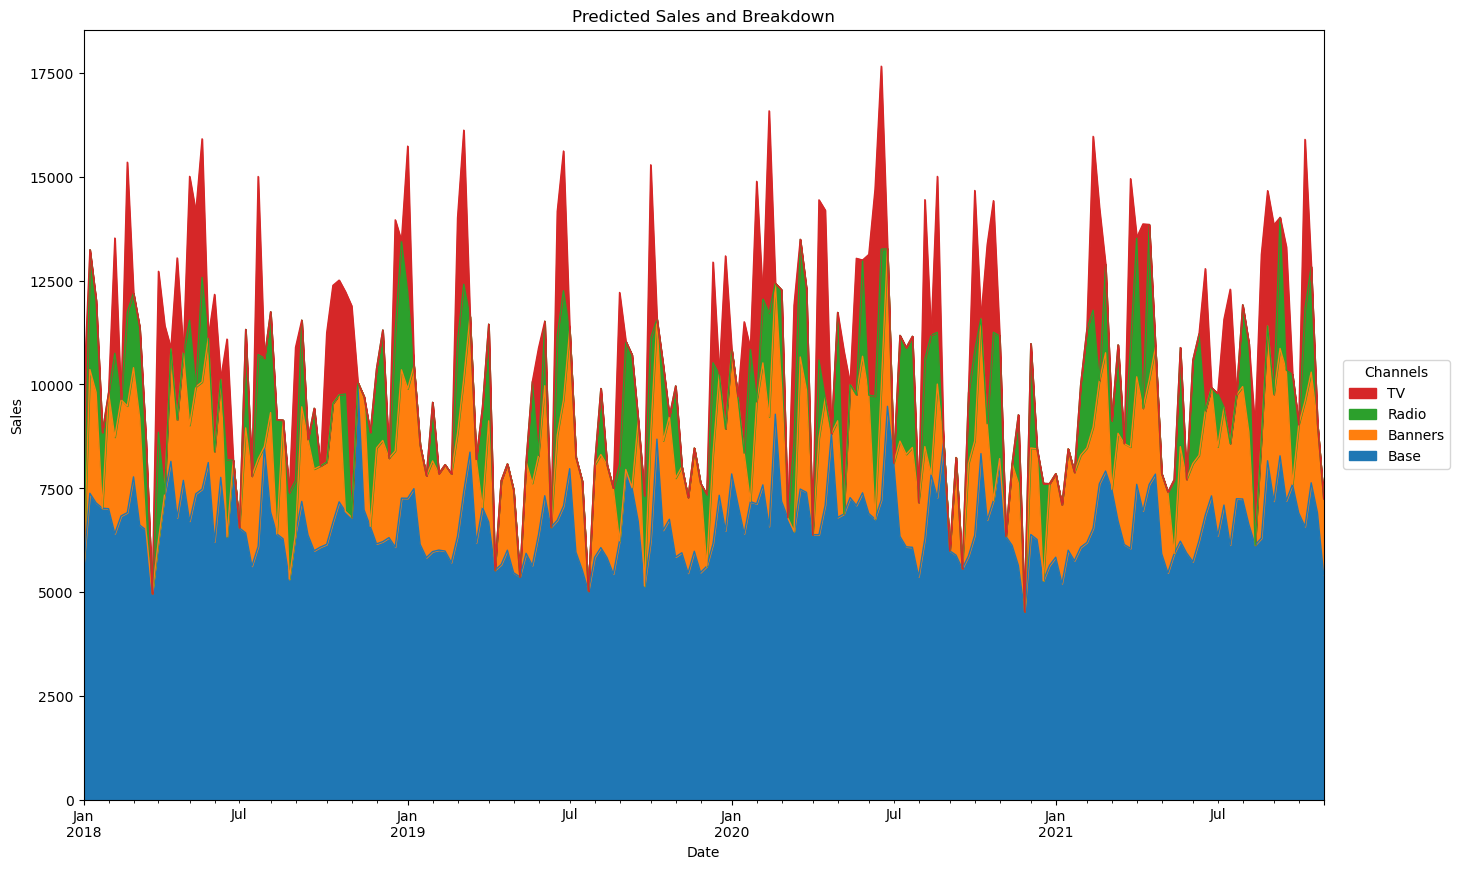

In [3]:
weights = pd.Series(
    lr.coef_,
    index=X.columns
)

base = lr.intercept_

unadj_contributions = X.mul(weights).assign(Base=base)

adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    ) # contains all contributions for each day

ax = (adj_contributions[['Base', 'Banners', 'Radio', 'TV']]
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date')
     )

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)

In [4]:
sales_from_tv = adj_contributions['TV'].sum()
spendings_on_tv = data['TV'].sum()
tv_roi = sales_from_tv / spendings_on_tv
# tv_roi is around 0.36
tv_roi

0.3602450071355313

In [5]:
import numpy as np

In [6]:
class ExponentialSaturation:
    def __init__(self, a=1.):
        self.a = a
        
    def transform(self, X):
        return 1 - np.exp(-self.a*X)

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array

class ExponentialSaturation(BaseEstimator, TransformerMixin):
    def __init__(self, a=1.):
        self.a = a
        
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True) # from BaseEstimator
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False) # from BaseEstimator
        return 1 - np.exp(-self.a*X)


In [8]:
from scipy.signal import convolve2d
import numpy as np

class ExponentialCarryover(BaseEstimator, TransformerMixin):
    def __init__(self, strength=0.5, length=1):
        self.strength = strength
        self.length = length

    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        self.sliding_window_ = (
            self.strength ** np.arange(self.length + 1)
        ).reshape(-1, 1)
        return self

    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        convolution = convolve2d(X, self.sliding_window_)
        if self.length > 0:
            convolution = convolution[: -self.length]
        return convolution

In [9]:
from scipy.signal import convolve2d
import numpy as np

class ExponentialCarryover(BaseEstimator, TransformerMixin):
    def __init__(self, strength=0.5, length=1):
        self.strength = strength
        self.length = length

    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        self.sliding_window_ = (
            self.strength ** np.arange(self.length + 1)
        ).reshape(-1, 1)
        return self

    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        convolution = convolve2d(X, self.sliding_window_)
        if self.length > 0:
            convolution = convolution[: -self.length]
        return convolution

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

adstock = ColumnTransformer(
    [
     #### TV block ####
     ('tv_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['TV']),
     ('radio_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Radio']),
     ('banners_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Banners']),
    ],
    remainder='passthrough'
)

model = Pipeline([
                  ('adstock', adstock),
                  ('regression', LinearRegression())
])


In [11]:
import pandas as pd
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

data = pd.read_csv(
    'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date'
)

X = data.drop(columns=['Sales'])
y = data['Sales']

model.fit(X, y)

print(cross_val_score(model, X, y, cv=TimeSeriesSplit()).mean())

# Output: ~0.55


0.5527190073236669


In [12]:
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution

tuned_model1 = OptunaSearchCV(
    estimator=model,
    param_distributions={
        'adstock__tv_pipe__carryover__strength': FloatDistribution(0, 1),
        'adstock__tv_pipe__carryover__length': IntDistribution(0, 6),
        'adstock__tv_pipe__saturation__a': FloatDistribution(0, 0.01),
        'adstock__radio_pipe__carryover__strength': FloatDistribution(0, 1),
        'adstock__radio_pipe__carryover__length': IntDistribution(0, 6),
        'adstock__radio_pipe__saturation__a': FloatDistribution(0, 0.01),
        'adstock__banners_pipe__carryover__strength': FloatDistribution(0, 1),
        'adstock__banners_pipe__carryover__length': IntDistribution(0, 6),
        'adstock__banners_pipe__saturation__a': FloatDistribution(0, 0.01),
    },
    n_trials=10,
    cv=TimeSeriesSplit(),
    random_state=0
)

/home/hughmallinson/mambaforge/envs/my_conda_env_with_py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_7467/1295891779.py:4: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  tuned_model1 = OptunaSearchCV(


In [13]:
print(cross_val_score(tuned_model1, X, y, cv=TimeSeriesSplit()))

/home/hughmallinson/mambaforge/envs/my_conda_env_with_py311/lib/python3.11/site-packages/sklearn/base.py:109: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  new_object = klass(**new_object_params)
[I 2023-08-20 17:07:29,658] A new study created in memory with name: no-name-16056be8-16d6-454e-ba10-6a4dc72dca20
[I 2023-08-20 17:07:29,898] Trial 0 finished with value: -347726.57392333384 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4860473230215504, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.009855760506615989, 'adstock__radio_pipe__carryover__strength': 0.1955964101622225, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.00980582177099305, 'adstock__banners_pipe__carryover__strength': 0.18048029738995275, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.008463095456331128}. Best is trial 0 w

[0.37373789 0.61829836 0.27064995 0.68473676 0.48483201]


In [15]:
from ray.tune.sklearn import TuneGridSearchCV

from scipy.stats import uniform, randint

tuned_model3 = TuneGridSearchCV(
    estimator=model,
    param_grid={
        'adstock__tv_pipe__carryover__strength': [0, 1],
        'adstock__tv_pipe__carryover__length': [0, 6],
        'adstock__tv_pipe__saturation__a': [0, 0.01],
        'adstock__radio_pipe__carryover__strength': [0, 1],
        'adstock__radio_pipe__carryover__length': [0, 6],
        'adstock__radio_pipe__saturation__a': [0, 0.01],
        'adstock__banners_pipe__carryover__strength': [0, 1],
        'adstock__banners_pipe__carryover__length': [0, 6],
        'adstock__banners_pipe__saturation__a': [0, 0.01],
    },
    max_iters=1,
    early_stopping=False,
    n_jobs=-1,
    verbose=0,
    cv=TimeSeriesSplit(),
)

/home/hughmallinson/mambaforge/envs/my_conda_env_with_py311/lib/python3.11/site-packages/tune_sklearn/tune_basesearch.py:365: UserWarning: max_iters is set > 1 but incremental/partial training is not enabled. To enable partial training, ensure the estimator has `partial_fit` or `warm_start` and set `early_stopping=True`. Automatically setting max_iters=1.
  warnings.warn(


In [ ]:
tuned_model3.fit(X, y)
#print(cross_val_score(tuned_model3, X, y, cv=TimeSeriesSplit()))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

tuned_model2 = RandomizedSearchCV(
    estimator=model,
    param_distributions={
        'adstock__tv_pipe__carryover__strength': uniform(0, 1),
        'adstock__tv_pipe__carryover__length': randint(0, 6),
        'adstock__tv_pipe__saturation__a': uniform(0, 0.01),
        'adstock__radio_pipe__carryover__strength': uniform(0, 1),
        'adstock__radio_pipe__carryover__length': randint(0, 6),
        'adstock__radio_pipe__saturation__a': uniform(0, 0.01),
        'adstock__banners_pipe__carryover__strength': uniform(0, 1),
        'adstock__banners_pipe__carryover__length': randint(0, 6),
        'adstock__banners_pipe__saturation__a': uniform(0, 0.01),
    },
    n_iter=400,
    cv=TimeSeriesSplit(),
    random_state=0
)

In [ ]:
print(cross_val_score(tuned_model2, X, y, cv=TimeSeriesSplit()))

In [ ]:
tuned_model2.fit(X, y)

In [ ]:
print(tuned_model2.best_params_)
print(tuned_model2.best_estimator_.named_steps['regression'].coef_)
print(tuned_model2.best_estimator_.named_steps['regression'].intercept_)


In [ ]:
tuned_model1.fit(X, y)
print(tuned_model1.best_params_)
print(tuned_model1.best_estimator_.named_steps['regression'].coef_)
print(tuned_model1.best_estimator_.named_steps['regression'].intercept_)


In [ ]:
adstock_data = pd.DataFrame(
    tuned_model2.best_estimator_.named_steps['adstock'].transform(X),
    columns=X.columns,
    index=X.index
)

weights = pd.Series(
    tuned_model2.best_estimator_.named_steps['regression'].coef_,
    index=X.columns
)

base = tuned_model2.best_estimator_.named_steps['regression'].intercept_

unadj_contributions = adstock_data.mul(weights).assign(Base=base)
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

ax = (adj_contributions[['Base', 'Banners', 'Radio', 'TV']]
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date'
      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)